In [ ]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#코랩 GPU확인
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import os #파일경로 불러오기용
import cv2 #이미지 처리용
from google.colab.patches import cv2_imshow #cv2 이미지 보여주기 함수 코랩 패치버전
import pandas as pd #데이터 프레임 조작용

In [ ]:
def create_df(data_path):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    df = pd.DataFrame({})
    data_dir_list = os.listdir(data_path)
    print(data_dir_list)
    for i in range(len(data_dir_list)):
      file_list = os.listdir(data_path + "/" + data_dir_list[i])
      img_path_list = []
      for j in range(len(file_list)):
        img_path = data_path + "/" + data_dir_list[i] + "/" +file_list[j]
        img_path_list.append(img_path)
      df = pd.concat([df,pd.DataFrame({'File_path':img_path_list,'Label':data_dir_list[i]})])
      print(data_dir_list[i],len(file_list))

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    return df

In [ ]:
df = create_df('/content/drive/MyDrive/PDC_2022/track1/submit/train')

['cse', 'wjj', 'rg', 'hh', 'wb']
cse 524
wjj 458
rg 495
hh 512
wb 473


In [ ]:
display(df)

,File_path,Label
0,/content/drive/MyDrive/PDC_2022/track1/submit/...,hh
1,/content/drive/MyDrive/PDC_2022/track1/submit/...,wb
2,/content/drive/MyDrive/PDC_2022/track1/submit/...,cse
3,/content/drive/MyDrive/PDC_2022/track1/submit/...,wjj
4,/content/drive/MyDrive/PDC_2022/track1/submit/...,wb
...,...,...
2457,/content/drive/MyDrive/PDC_2022/track1/submit/...,rg
2458,/content/drive/MyDrive/PDC_2022/track1/submit/...,hh
2459,/content/drive/MyDrive/PDC_2022/track1/submit/...,wjj
2460,/content/drive/MyDrive/PDC_2022/track1/submit/...,wjj


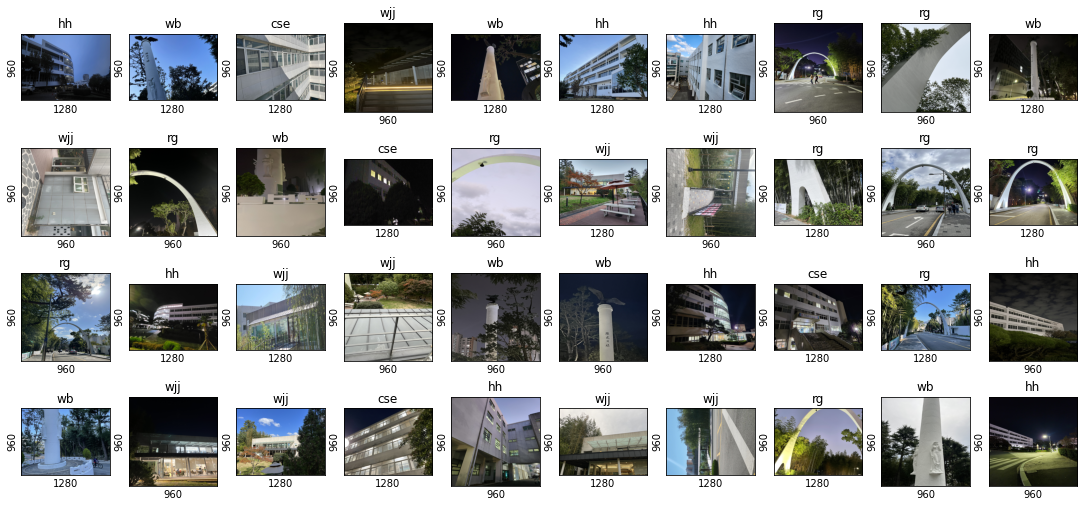

In [ ]:
import matplotlib.pyplot as plt
"""
  데이터 확인(이미지 라벨, 가로크기,세로크기)
"""
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.File_path[i]))
    img = cv2.imread(df.File_path[i])
    ax.set_title(df.Label[i], fontsize = 12)
    ax.set_xlabel(img.shape[1], fontsize=10)
    ax.set_ylabel(img.shape[0], fontsize=10)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
"""
  훈련데이터,테스트데이터로 나누기, 9:1, 계층샘플링적용
"""
train_df,val_df = train_test_split(df, test_size=0.1,random_state=0,stratify=df.Label)
train_df.shape,val_df.shape

test_df = create_df('/content/drive/MyDrive/PDC_2022/track1/submit/test')

['cse', 'hh', 'rg', 'wb', 'wjj']
cse 54
hh 59
rg 51
wb 49
wjj 55


In [ ]:
import numpy as np
import tensorflow as tf
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    val_images = val_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,val_generator,test_generator,train_images,val_images,test_images


In [ ]:
train_generator,val_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 2215 validated image filenames belonging to 5 classes.
Found 247 validated image filenames belonging to 5 classes.
Found 268 validated image filenames belonging to 5 classes.


In [ ]:
len(train_images)

70

In [ ]:
#2층 CNN모델
#GPU훈련
with tf.device('/device:GPU:0'):
  # 시퀀셜모델(레이어모델) 생성
  cnn = tf.keras.models.Sequential()

  # 1층 convolution&pooling
  cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))
  cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

  # 2층 convolution&pooling
  cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
  cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

  # 3층 convolution 레이어에서 나온 특징 평탄화
  cnn.add(tf.keras.layers.Flatten())

  # 4층 완전연결신경망
  cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

  # 5층 Softmax분류결과출력 신경망
  cnn.add(tf.keras.layers.Dense(units=5, activation='softmax'))

  # compile,adam,categorical_crossentropy
  cnn.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
  cnn.summary()

  #에포크 10 훈련
  history = cnn.fit(x = train_images,validation_data=val_images,epochs=10,verbose=1)



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 41472)             0         
                                                                 
 dense_14 (Dense)            (None, 128)              

In [ ]:
#모델 저장
cnn.save('baseline_cnn_val_acc_0.7.h5')

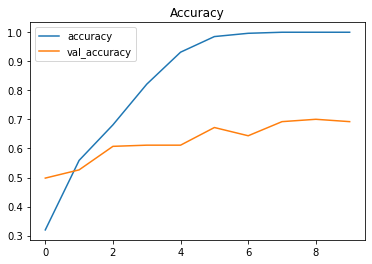

In [ ]:
#정확도그래프
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

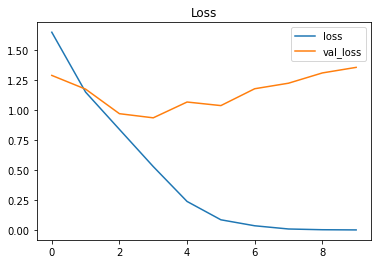

In [ ]:
#오차그래프
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
test_images.class_indices

{'cse': 0, 'hh': 1, 'rg': 2, 'wb': 3, 'wjj': 4}

번호 입력 : 10
1/1 [==============================] - 6s 6s/step


'예측률 : 100.00%'

'클래스 = cse'

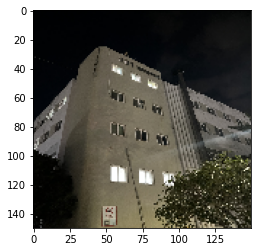

In [ ]:
#모델 로드 후 개별 이미지 예측 테스트
import pandas as pd
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
def printmd(string):
    display(string)
class_dictionary = test_images.class_indices
model = load_model('/content/drive/MyDrive/PDC_2022/test/baseline_cnn_val_acc_0.7.h5')
IMAGE_SIZE    = (150, 150)
number_1 = int(input("번호 입력 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"클래스 = {x}")
    break

1/1 [==============================] - 0s 18ms/step


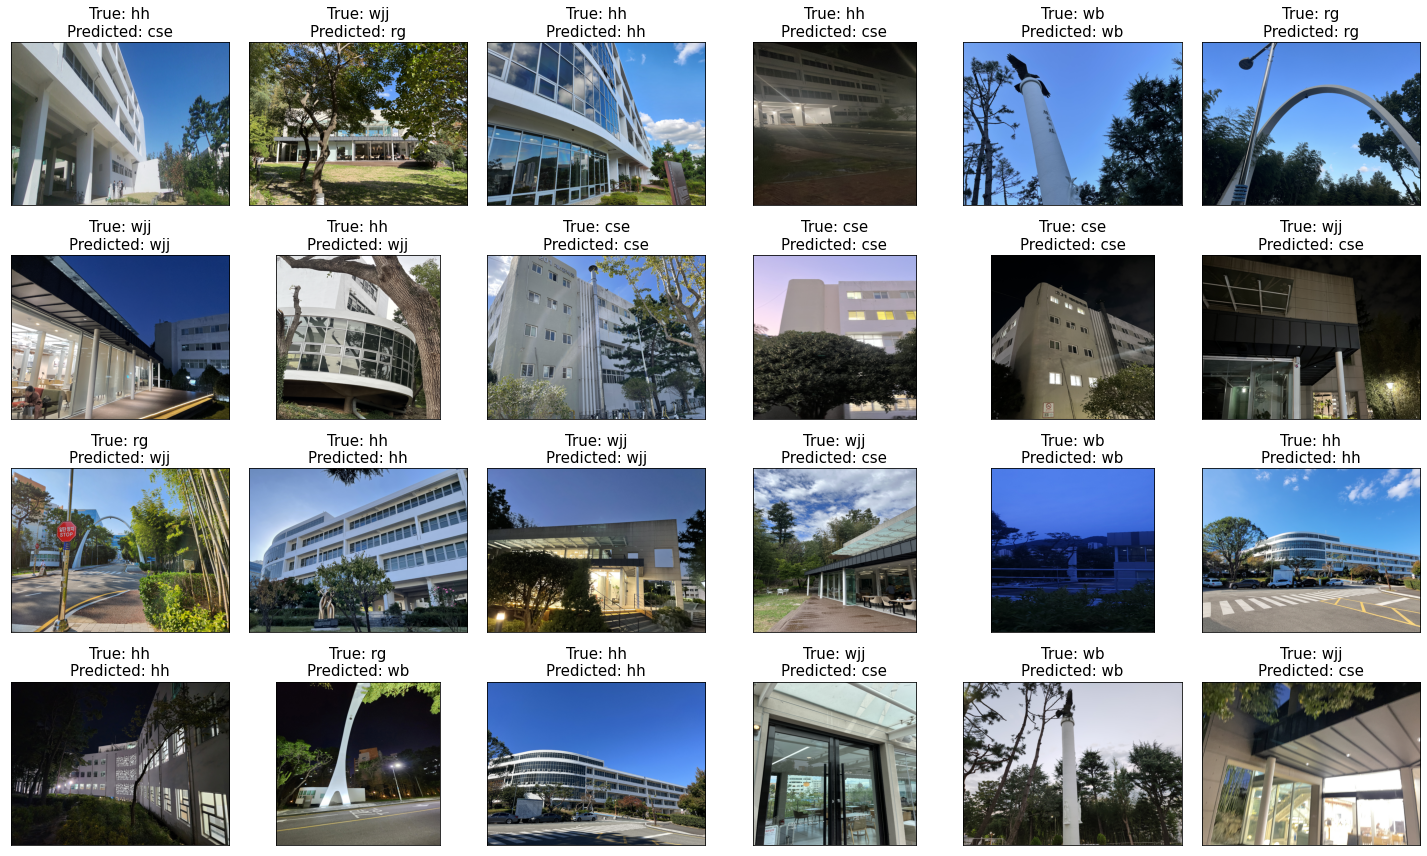

In [ ]:
#여러 이미지 테스트
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.File_path.iloc[i]))
    test_image = image.load_img(test_df.iloc[i, 0]
                            ,target_size =IMAGE_SIZE )
    test_image = image.img_to_array(test_image)
    test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
    prediction = model.predict(test_image)
    df = pd.DataFrame({'pred':prediction[0]})
    df = df.sort_values(by='pred', ascending=False, na_position='first')
    for x in class_dictionary:
      if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
        ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {x}", fontsize = 15)
plt.tight_layout()
plt.show()